## WatsonianAdventure

# Phase1: dataset selection & preprocessing 



## Goal
In order to determine the relation between two statements (a premise followed by a hypothesis), this project aims to create a machine-learning model that can classify and label the relationship with (contradiction, entailment, and neutral). There are several applications for this issue, including text summarization, question answering, and information retrieval.



In [25]:
#import needed libraries
from langdetect import detect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

## Source of the Dataset
The dataset was collected for the "Contradictory, My Dear Watson" Kaggle competition https://www.kaggle.com/competitions/contradictory-my-dear-watson/data?select=train.csv)

In [4]:
# load the dataset
df = pd.read_csv(r'../Dataset/train.csv')

## Data summary (descriptive analysis)

#### Numbers and data decription


In [5]:
#we have 12,120 columns and 6 rows
df.shape

(12120, 6)

In [6]:
df.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')

### Data distrbution and visualization


As it shows below. we have 4176 records labeled as entailment, 4064 neutral, and 3880 contradiction.

In [7]:
df['label'].value_counts()

label
0    4176
2    4064
1    3880
Name: count, dtype: int64

In [8]:
# adding column called category to visualize each (0 for entailment, 1 for neutral, 2 for contradiction)
def category(label):
    if label == 0:
        return 'entailment'
    elif label == 1:
        return 'neutral'
    elif label ==2:
        return 'contradiction'

df['category'] = df['label'].apply(category)

Visualizing the dataset indicates that each one of the categories has an approximately equal number of records

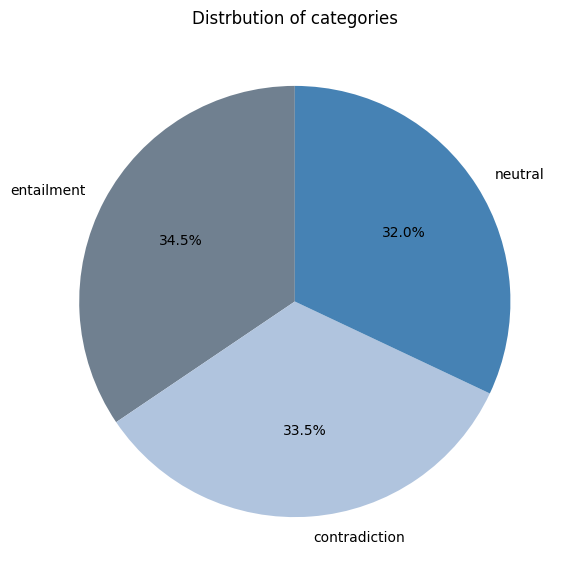

In [9]:
#using pie chart 

fig = plt.figure(figsize=(7,7))
colors = ("slategrey", "lightsteelblue", "steelblue")
tags = df['category'].value_counts()
explode = (0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', colors = colors,
         startangle=90, label='')
plt.title('Distrbution of categories')
fig.set_facecolor('white')

<Axes: xlabel='category', ylabel='count'>

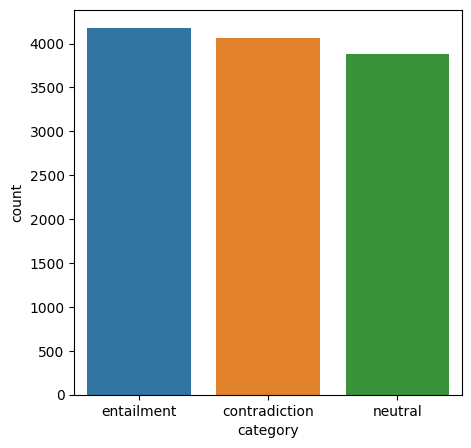

In [10]:
#using bar chart
fig = plt.figure(figsize=(5,5))
sns.countplot(x='category', data = df)

### Missing values

turns out the dataset has no missing values as it says in the non-null count

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
 6   category    12120 non-null  object
dtypes: int64(1), object(6)
memory usage: 662.9+ KB


### Sattistical summaries

For each needed columns in training the models, we provided for each a statistical summary.And as it says below there are duplications in the dataset that need to be dropped in the cleaning and preprocessing

In [12]:
df['premise'].describe()

count                                                 12120
unique                                                 8209
top       and these comments were considered in formulat...
freq                                                      3
Name: premise, dtype: object

In [13]:
df['hypothesis'].describe()

count              12120
unique             12119
top       I am not sure.
freq                   2
Name: hypothesis, dtype: object

In [14]:
df['label'].describe()

count    12120.000000
mean         0.990759
std          0.824523
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: label, dtype: float64

### Sample

In [15]:
text_df = df.drop(['id','language','lang_abv',],axis=1)
text_df.head(5)

,premise,hypothesis,label,category
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,entailment
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,contradiction
2,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,0,entailment
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,entailment
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,1,neutral


## Data preprocessing and cleaning

**We are going to start cleaning and preprocessing dataset by applying the following :**
- Dropping non-english records

- Removing duplications

- Removing punctuations

- Remove stop words

- Tokenization

- Stemming 

- Word Embeddings 

### Dropping non english records

Dropping non-english records since the models we're going to use and train are specific to the English language and this step will impove its performance

In [16]:
df.drop(df.index[df['lang_abv'] != 'en'], inplace=True)
print(df.language.value_counts())

language
English    6870
Name: count, dtype: int64


In [17]:
df.shape

(6870, 7)

### Removing duplications

We have to remove duplications to avoid overfitting, which occurs when the model learns the training data too well and performs poorly on new, unseen data. Furthermore, removing duplicates helps reduce the risk of overfitting by providing a more diverse set of training data. Also, it can reduce the amount of data that needs to be processed during training, which can improve the efficiency of the modeling process and reduce the time and computational resources required.

In [18]:
df.drop_duplicates(subset='premise', inplace=True)
df.drop_duplicates(subset='hypothesis', inplace=True)

In [19]:
#to make sure we don't have any duplications 
print(sum(df.duplicated(subset='premise')))
print(sum(df.duplicated(subset='hypothesis')))

0
0


### Removing punctuations

Punctuation marks can significantly increase the dimensionality of the data, which can make it more difficult to analyze and model. By removing punctuation, we can reduce the dimensionality of the data and simplify the modeling process. It also can help improve the accuracy of the model by reducing the amount of noise in the data.

In [20]:
def remove_punctuations(col):
   translator = str.maketrans('','',string.punctuation)
   return col.translate(translator)

df['premise'] = df['premise'].apply(remove_punctuations)
df['hypothesis'] = df['hypothesis'].apply(remove_punctuations)
display(df.head(10))

,id,premise,hypothesis,lang_abv,language,label,category
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,entailment
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,contradiction
3,5622f0c60b,you know they cant really defend themselves li...,They cant defend themselves because of their age,en,English,0,entailment
7,fdcd1bd867,From Cockpit Country to St Anns Bay,From St Anns Bay to Cockpit Country,en,English,2,contradiction
8,7cfb3d272c,Look its your skin but youre going to be in tr...,The boss will fire you if he sees you slacking...,en,English,1,neutral
16,dd4f0d9f25,If you people only knew how fatally easy it is...,Many people have poisoned someone by mistake,en,English,1,neutral
17,0a3f52c547,My own little corner of the world policy wonki...,An example is policy wonking,en,English,0,entailment
18,4b0eca3ccb,life in prison then hes available for parole i...,The system is corrupt because he wont be able ...,en,English,1,neutral
19,cad235551c,The streets are crammed with vendors selling s...,Vendors have lined the streets with torches an...,en,English,2,contradiction
20,d8b3a4fb06,North of Mytilini stop at the village of Moria...,There is nothing special to see in the village...,en,English,2,contradiction


### Tokenization

Breaking down text into individual tokens or words. To represent text as a sequence of discrete symbols that can be processed by machine learning algorithms.

Tokenization is often used as a first step in feature extraction for machine learning models. By converting text data into a set of tokens, we can represent the text as a numerical feature vector that can be used as input to a machine learning model.

In [21]:
nltk.download('punkt')

# tokenize text
df['premise'] = df['premise'].apply(lambda x: word_tokenize(str(x)))
df['hypothesis'] = df['hypothesis'].apply(lambda x: word_tokenize(str(x)))

[nltk_data] Downloading package punkt to /Users/2rwak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Stop word removal

Stop words are commonly used words in a language. Examples of stop words in English include "the", "and", "a", "an", "in", "on", etc. We remove them because they don't carry much meaning in the context of the text and can add noise to the analysis.

The reason for that is to simplify the modeling process, improve accuracy, ensure consistency, and speed up processing.

In [22]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
df['premise'] = df['premise'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))
df['hypothesis'] = df['hypothesis'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /Users/2rwak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

 Normalize the words to their base form, which can help reduce the dimensionality of the data and improve the accuracy of the model. Stemming involves removing the suffixes from words to reduce them to their root form (e.g., "jumping" to "jump").

 Stemming can help to improve the accuracy of NLP models by reducing the number of unique words in the data and speed up the processing of text data by reducing the number of unique words that need to be processed

In [23]:
# Create a stemmer object
stemmer = PorterStemmer()

# Define a function to perform stemming on a text column
def stem_text(text):
    # Tokenize the text into words
    words = text.split()

    # Stem each word in the list
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the stemmed words back into a single string
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# Apply the stemming function to a text column in the dataset
df['premise'] = df['premise'].apply(stem_text)
df['hypothesis'] = df['hypothesis'].apply(stem_text)

# Print the first few rows of the stemmed dataset
print(df.head())

           id                                            premise   
0  5130fd2cb5  ['and', 'these', 'comments', 'were', 'consider...  \
1  5b72532a0b  ['these', 'are', 'issues', 'that', 'we', 'wres...   
3  5622f0c60b  ['you', 'know', 'they', 'cant', 'really', 'def...   
7  fdcd1bd867  ['from', 'cockpit', 'country', 'to', 'st', 'an...   
8  7cfb3d272c  ['look', 'its', 'your', 'skin', 'but', 'youre'...   

                                          hypothesis lang_abv language  label   
0  ['the', 'rules', 'developed', 'in', 'the', 'in...       en  English      0  \
1  ['practice', 'groups', 'are', 'not', 'permitte...       en  English      2   
3  ['they', 'cant', 'defend', 'themselves', 'beca...       en  English      0   
7  ['from', 'st', 'anns', 'bay', 'to', 'cockpit',...       en  English      2   
8  ['the', 'boss', 'will', 'fire', 'you', 'if', '...       en  English      1   

        category  
0     entailment  
1  contradiction  
3     entailment  
7  contradiction  
8        

### Word embeddings

Representing text data as high-dimensional vectors. To capture the semantic relationships between words and phrases, which can improve the accuracy of your machine learning model.

Word embedding provides a more efficient representation of text data than one-hot encoding, which can be very sparse and high-dimensional. Also, it compresses the word representation into a dense vector, which can capture more nuanced relationships between words.

In [26]:
from gensim.models import KeyedVectors

# load the pre-trained GloVe embeddings
# download the GloVe embeddings file from the official website at https://nlp.stanford.edu/projects/glove/.
glove_model = KeyedVectors.load_word2vec_format('/Users/2rwak/Desktop/contradictory-my-dear-watson/glove.6B.100d.txt', binary=False, no_header=True)

# convert premise and hypothesis to their vector representations
premise_vectors = []
for premise in df['premise']:
    tokens = word_tokenize(premise)
    vectors = [glove_model[word] for word in tokens if word in glove_model.key_to_index]
    if len(vectors) > 0:
        premise_vectors.append(np.mean(vectors, axis=0))
    else:
        premise_vectors.append(np.zeros((100,)))
df['premise_vectors'] = premise_vectors

hypothesis_vectors = []
for hypothesis in df['hypothesis']:
    tokens = word_tokenize(hypothesis)
    vectors = [glove_model[word] for word in tokens if word in glove_model.key_to_index]
    if len(vectors) > 0:
        hypothesis_vectors.append(np.mean(vectors, axis=0))
    else:
        hypothesis_vectors.append(np.zeros((100,)))
df['hypothesis_vectors'] = hypothesis_vectors


In [27]:
# drop unnecessary columns
df = df = df.drop(columns=['id','language','lang_abv','category'])

In [28]:
df.head(10)

,premise,hypothesis,label,premise_vectors,hypothesis_vectors
0,"['and', 'these', 'comments', 'were', 'consider...","['the', 'rules', 'developed', 'in', 'the', 'in...",0,"[-0.22779953, -0.021100001, 0.553289, -0.67628...","[-0.22748104, -0.034506895, 0.564092, -0.68762..."
1,"['these', 'are', 'issues', 'that', 'we', 'wres...","['practice', 'groups', 'are', 'not', 'permitte...",2,"[-0.2274271, -0.036777418, 0.56592155, -0.6895...","[-0.22779953, -0.021100001, 0.553289, -0.67628..."
3,"['you', 'know', 'they', 'cant', 'really', 'def...","['they', 'cant', 'defend', 'themselves', 'beca...",0,"[-0.22733772, -0.04054, 0.5689534, -0.6927331,...","[-0.22807117, -0.009664707, 0.5440747, -0.6666..."
7,"['from', 'cockpit', 'country', 'to', 'st', 'an...","['from', 'st', 'anns', 'bay', 'to', 'cockpit',...",2,"[-0.22826132, -0.0016600012, 0.5376247, -0.659...","[-0.22826132, -0.0016600012, 0.5376247, -0.659..."
8,"['look', 'its', 'your', 'skin', 'but', 'youre'...","['the', 'boss', 'will', 'fire', 'you', 'if', '...",1,"[-0.2273797, -0.03877273, 0.5675293, -0.691238...","[-0.22769913, -0.025326088, 0.55669427, -0.679..."
16,"['if', 'you', 'people', 'only', 'knew', 'how',...","['many', 'people', 'have', 'poisoned', 'someon...",1,"[-0.22720882, -0.045965116, 0.57332486, -0.697...","[-0.22826132, -0.0016600012, 0.5376247, -0.659..."
17,"['my', 'own', 'little', 'corner', 'of', 'the',...","['an', 'example', 'is', 'policy', 'wonking']",0,"[-0.2276148, -0.028876001, 0.5595547, -0.68286...","[-0.22884908, 0.023081815, 0.5176882, -0.63891..."
18,"['life', 'in', 'prison', 'then', 'hes', 'avail...","['the', 'system', 'is', 'corrupt', 'because', ...",1,"[-0.22944252, -0.055460062, 0.5709463, -0.6989...","[-0.231451, -0.045236513, 0.5555074, -0.685784..."
19,"['the', 'streets', 'are', 'crammed', 'with', '...","['vendors', 'have', 'lined', 'the', 'streets',...",2,"[-0.22720882, -0.045965116, 0.57332486, -0.697...","[-0.22792105, -0.015984213, 0.54916686, -0.671..."
20,"['north', 'of', 'mytilini', 'stop', 'at', 'the...","['there', 'is', 'nothing', 'special', 'to', 's...",2,"[-0.23032019, -0.05099263, 0.5641998, -0.69322...","[-0.22769913, -0.025326088, 0.55669427, -0.679..."


In [29]:
# save the data after cleaning and preprocessing
df.to_csv('train_after_cleanning.csv', index=False)